In [52]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, op={self._op})"

    def __add__(self, other):     
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):        
        out = Value(self.data  * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo=[]
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [54]:
a = Value(2.0)

In [55]:
a + 1

AttributeError: 'int' object has no attribute 'data'

In [56]:
1 + a

TypeError: unsupported operand type(s) for +: 'int' and 'Value'

In [57]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        #return f"Value(data={self.data}, op={self._op})"
        return f"Value(data={self.data})"

    def __add__(self, other):  
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):     
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'^{other}')

        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __rsub__(self, other):
        return self - other
        
    def __rmul__(self, other):
        return self * other

    def __sub__(self, other):
        return self + (-other)

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out 

    def backward(self):
        topo=[]
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [58]:
a = Value(2.0)
a + 1

Value(data=3.0)

In [59]:
1 + a

Value(data=3.0)

In [60]:
a * 2

Value(data=4.0)

In [61]:
a - 1

Value(data=1.0)

In [62]:
-a

Value(data=-2.0)

In [63]:
a / a

Value(data=1.0)

In [64]:
a / 2

Value(data=1.0)

In [65]:
a.exp()

Value(data=7.38905609893065)

In [66]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
                
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
  
    for n in nodes:
        uid = str(id(n))
    
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data: %.4f | grad: %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [67]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1 x w1'
x2w2 = x2*w2; x2w2.label = 'x2 x w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1 x w1 + x2 x w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

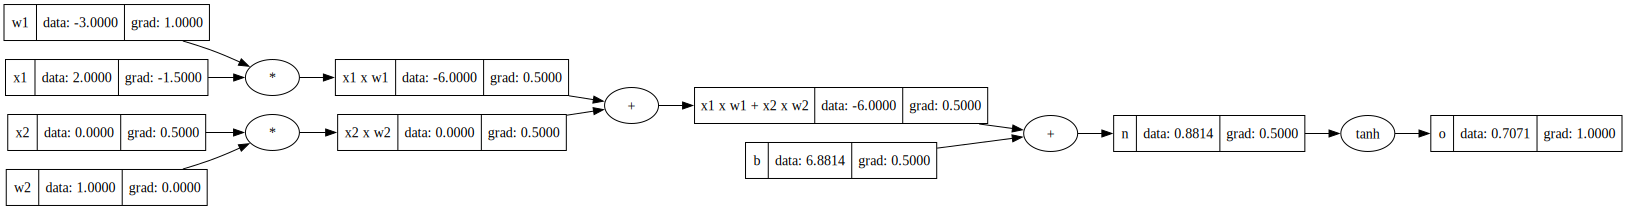

In [68]:
draw_dot(o)

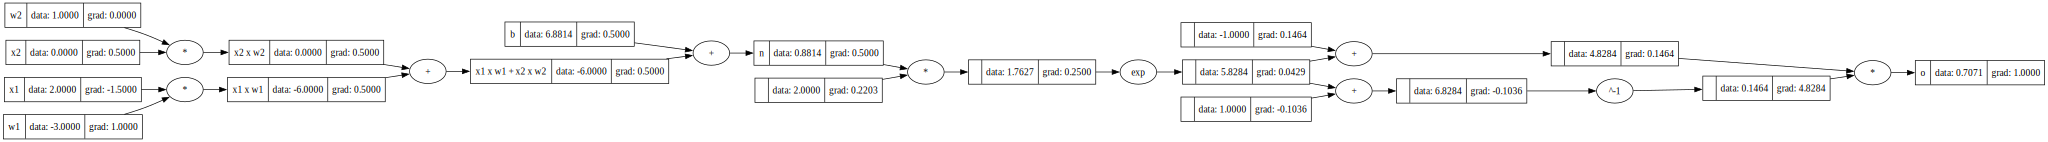

In [69]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1 x w1'
x2w2 = x2*w2; x2w2.label = 'x2 x w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1 x w1 + x2 x w2'
n = x1w1x2w2 + b; n.label = 'n'
# -----
e = (2 * n).exp()
o = (e - 1)/(e + 1)
o.label = 'o'
# -----
o.backward()
draw_dot(o)

In [70]:
import torch

In [71]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print('o.data', o.data.item())
o.backward()

print('------------------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

o.data 0.7071066904050358
------------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [72]:
torch.Tensor([[2.0, 3.2],[1.3, 5.0]]) 

tensor([[2.0000, 3.2000],
        [1.3000, 5.0000]])

In [73]:
torch.Tensor([2]).double().dtype

torch.float64

In [74]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # print(list(zip(self.w, x)))
        # return 0.0
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out
    
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.9977496037748459)

In [75]:
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

In [76]:
x = [2.0, 3.0]
l = Layer(2, 3)
l(x)

[Value(data=0.9853129514327935),
 Value(data=-0.29600274477823457),
 Value(data=-0.882228306803675)]

In [77]:
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [140]:
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)

Value(data=0.05435594785957019)

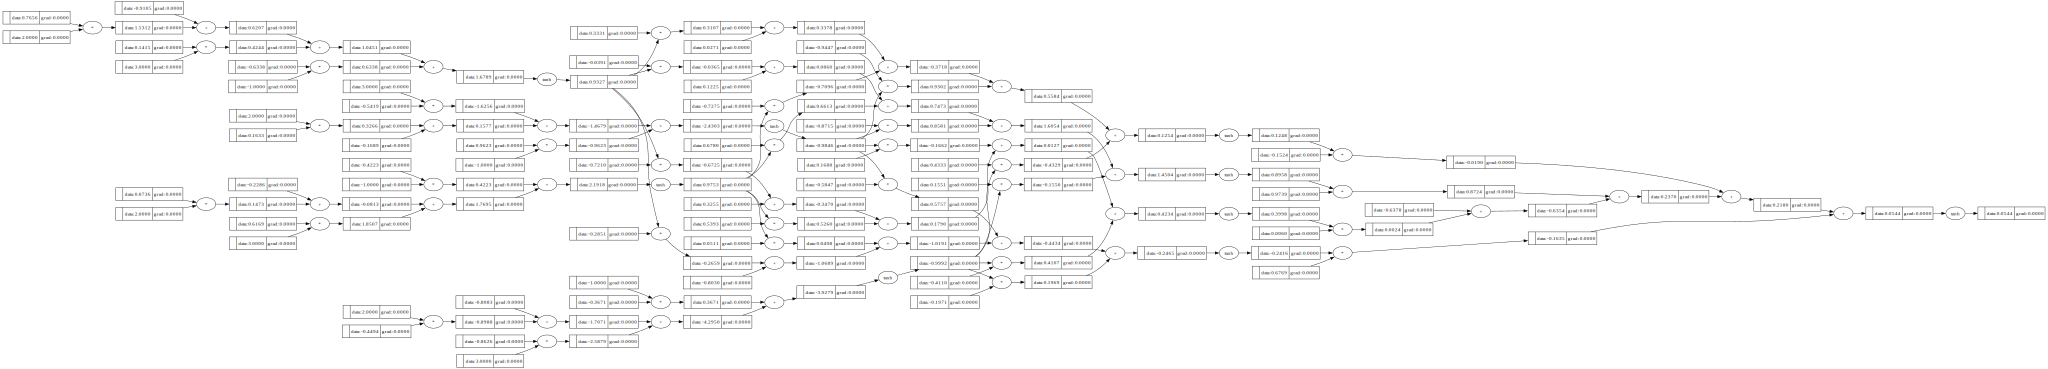

In [141]:
draw_dot(mlp(x))

In [142]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets 
ypred = [mlp(x) for x in xs]
ypred

[Value(data=0.05435594785957019),
 Value(data=-0.9641489094594744),
 Value(data=-0.8129596626750203),
 Value(data=0.022064195455536274)]

In [143]:
# Let's compute the mean square loss

[(ygt - yout)**2 for ygt, yout in zip(ys, ypred)]

[Value(data=0.8942426733485719),
 Value(data=0.001285300692944964),
 Value(data=0.0349840877866422),
 Value(data=0.9563584378100275)]

In [144]:
#let's compute mean square loss
loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=1.8868704996381864)

In [145]:
loss.backward()

In [146]:
mlp.layers[0].neurons[0].w[0]

Value(data=0.7655862636092061)

In [147]:
mlp.layers[0].neurons[0].w[0].grad

0.4479837120503104

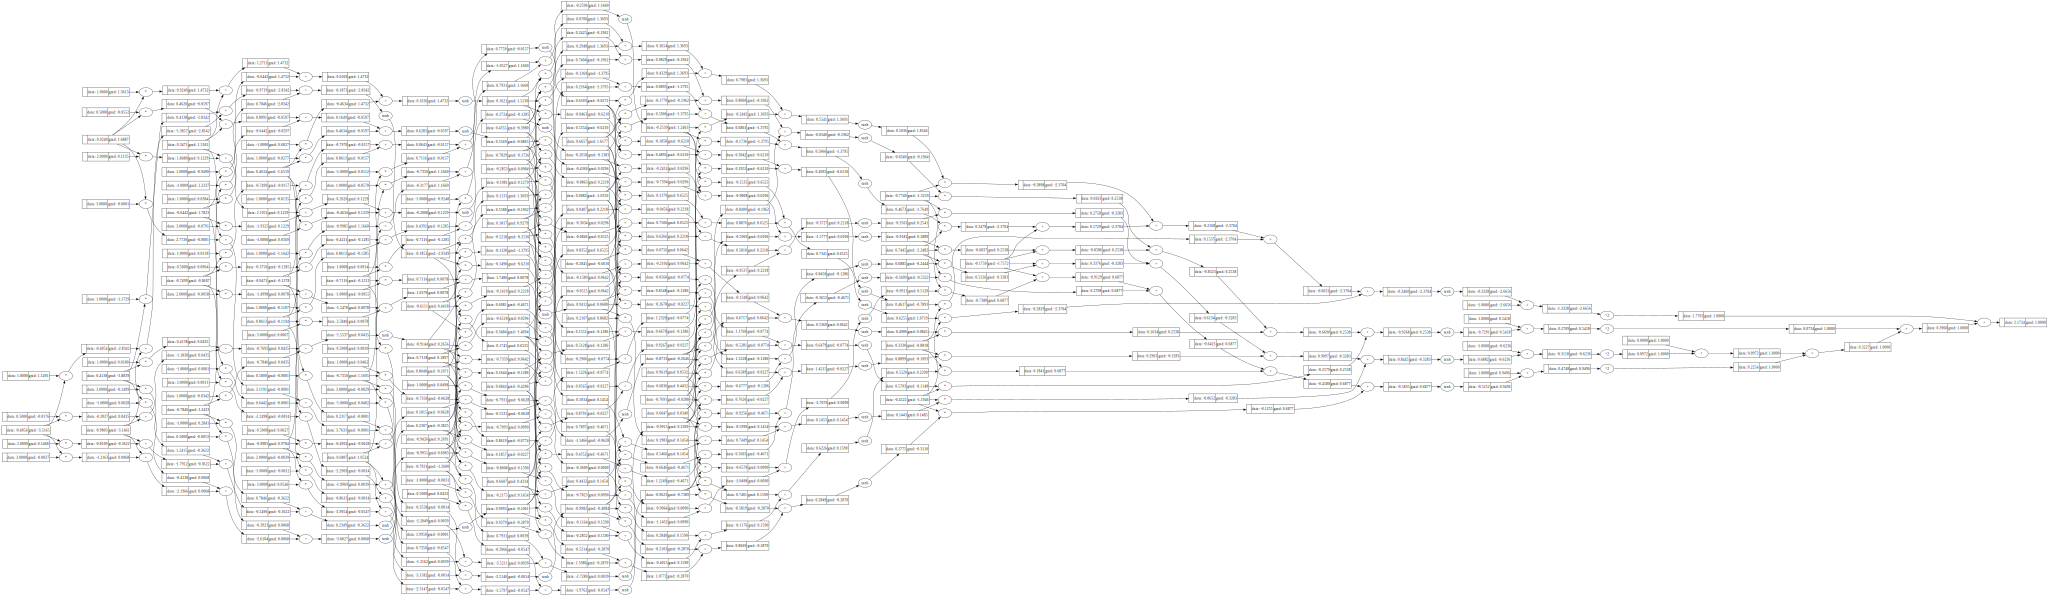

In [156]:
draw_dot(loss)

In [150]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]
        

In [151]:
mlp = MLP(3, [4, 4, 1])

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets 
ypred = [mlp(x) for x in xs]
ypred

[Value(data=0.6881833601440341),
 Value(data=-0.5252061393678304),
 Value(data=-0.7291148321301505),
 Value(data=-0.33278897789809)]

In [152]:
len(mlp.parameters())

41

In [153]:
loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=2.172364060763577)

In [155]:
loss.backward() 

In [159]:
mlp.layers[0].neurons[0].w[0].data

-0.40543176530721237

In [160]:
mlp.layers[0].neurons[0].w[0].grad

-3.516460734001691

In [173]:
for param in mlp.parameters():
    param.data += -0.01 * param.grad

In [174]:
ypred = [mlp(x) for x in xs]
loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.1654248261506332)

In [172]:
loss.backward()

In [176]:
# Now the Prediction is expected to be better
ypred

[Value(data=0.9678441895469526),
 Value(data=-0.7411588335137791),
 Value(data=-0.6923834382303156),
 Value(data=0.9474249920419285)]

In [ ]:
# Running Gradiant Decent

In [178]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets 

mlp = MLP(3, [4, 4, 1])

In [179]:
for k in range(20):

    #forward pass
    ypred = [mlp(x) for x in xs]
    loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])

    #backward pass
    for param in mlp.parameters():
        param.grad = 0
    loss.backward()

    #update
    for param in mlp.parameters():
        param.data += -0.05 * param.grad

    print(k, loss.data)
    

0 4.878040375416999
1 2.07320230150581
2 0.905059942482939
3 0.4586393675581577
4 0.28864133636364653
5 0.2057696973503516
6 0.1579756036284789
7 0.1272678951269478
8 0.10603411966118872
9 0.09055400029745264
10 0.07881047525918145
11 0.06962134699291826
12 0.06225057334280376
13 0.05621726652774726
14 0.05119464484862794
15 0.04695327205702747
16 0.04332755348900302
17 0.040195117966616754
18 0.03746367032120268
19 0.035062346487830284


In [180]:
ypred

[Value(data=0.9535800224965538),
 Value(data=-0.9780893598011204),
 Value(data=-0.870731104967618),
 Value(data=0.8746325050118968)]